# Pronóstico basado catálogos de terremotos simulados - El caso del modelo UCERF3-ETAS (Uniform California Earthquake Rate Forecast v3 -Epidemic-Type Aftershock Sequence) durante el terremoto de Landers de 1992

En este tutorial, demostraremos cómo evaluar pronósticos de sismicidad que utilizan catálogos simulados. Particularmente, evaluaremos si el número de terremotos pronosticado por el modelo llamado UCERF3-ETAS es consistente con el número de terremotos observados durante la sequencia de Landers (California, EUA) de 1992. 

pyCSEP se diseñó de modo que las evaluaciones de pronósticos de sismicidad en grillas sean semejantes a las evaluaciones de pronósticos basados en simulaciones. Así, este tutorial tiene el objetivo de familiarizar a lxs usuarixs con algunas de las diferencias entre ambas familias de evaluaciones y aprender a realizar estas nuevas pruebas CSEP.

La documentación completa del paquete se puede encontrar [aqui](https://docs.cseptesting.org/) y cualquier problema puede ser reportado en la [pagina Github de pyCSEP](https://github.com/SCECcode/pycsep). La teoría detrás de las evaluaciones de pronósticos basados en simulaciones se encuentra [aqui](https://docs.cseptesting.org/getting_started/theory.html#catalog-based-forecast-tests), mientras que los detalles de las rutinas se encuentran [aqui](https://docs.cseptesting.org/concepts/evaluations.html#catalog-based-forecast-evaluations).

In [2]:
# La función núcleo puede ser importada desde el nivel superior del paquete. 
import csep

# Alternativamente, lxs usuarixs pueden importar directamente submódulos tales como csep.core o csep.utils.
from csep.core import regions, catalog_evaluations
from csep.core import poisson_evaluations as poisson
from csep.utils import datasets, time_utils, comcat, plots

import numpy
import cartopy

## 1. Importar el pronóstico
Cada pronóstico debe definir el tiempo durante el cual es válido. Esta opción es flexible para pronósticos basados en simulaciones ya que los catálogos pueden ser filtrados de acuerdo a las fechas deseadas aunque, conceptualmente, estos deberían ser pronósticos diferentes.

Para pronósticos basados en catálogos simulados, necesitamos calcular explícitamente las tasas de sismicidad en cada celda espacial y/o "bin" de magnitud. Para ello, necesitamos definir primero la región espacial y el rango de magnitudes que deseamos analizar. Los bines de magnitud están definidos tradicionalmente de la forma {4.95, 5.05}, {5.05, 5.15}, ..., {8,95, inf}, donde el límite superior del último bin se extiende hasta infinito.

En comparación con los pronósticos basados en grillas que extraen su región espacial a partir de los archivos de entrada, los pronósticos basados en simulaciones requieren que esta información sea definida de manera explícita. En este ejercicio, utilizaremos el polígono RELM incluído en el paquete pyCSEP.

In [3]:
### Definamos los parámetros del modelo

# Fechas iniciales y finales
start_time = time_utils.strptime_to_utc_datetime("1992-06-28 11:57:34.14")
end_time = time_utils.strptime_to_utc_datetime("1992-07-28 11:57:34.14")

# Bines de magnitud
min_mw = 4.95
max_mw = 8.95
dmw = 0.1

# Creemos la región espacial y el rango de magnitudes. El pronóstico ya está filtrado a esta región y rango de magnitudes
magnitudes = regions.magnitude_bins(min_mw, max_mw, dmw)
region = regions.california_relm_region()

# Vinculemos la información de la región al pronóstico (esto se utilizará para agrupar después los catálogos)
space_magnitude_region = regions.create_space_magnitude_region(region, magnitudes)

Para reducir el tamaño del archivo que utilizaremos en este tutorial, hemos previamente aplicado un filtro a los catálogos simulados de modo que contengan las ubicaciones espaciales y magnitudes esperadas de las réplicas del sismo de Landers de 1992. El formato de pronósticos basados en grillas y en simulaciones es semejante y solo difieren en dos columnas extras que representan el "id" del catálogo sintético o el id el evento observado, respectivamente.

```
lon	        lat	        mag 	tiempo_origen	                prof	    catalogo_id	evento_id(opcional)
-124.56793	40.419548	5.65	1992-07-10T19:10:07.057000	18.083824	0	
-124.56	    40.4	    6.69	1992-08-30T16:44:54.183000	21.0    	0	
-124.319466	40.21936	5.15	1992-08-30T21:14:55.449000	6.1641793	0
...
-116.36257	33.96388	5.25	1992-09-11T14:57:55.473000	0.25818658	1	
-121.804115	35.214355	4.95	1992-11-15T13:46:20.408000	4.7234006	1
...	
```

El pronóstico se descarga ejecutando esta línea de código:

In [5]:
forecast = csep.load_catalog_forecast('ucerf3-landers.csv',
                                      start_time = start_time,
                                      end_time = end_time,
                                      region = space_magnitude_region)

El pronóstico fue originalmente creado para calcular tasas de sismicidad un año después de la ocurrencia del sismo de Landers, de modo que tenemos que aplicar un filtro temporal adicional de un mes. Para esto, pasamos al pronóstico una lista de paramétros de filtrado, tal y como sigue:

In [6]:
forecast.filters = [f'origin_time >= {forecast.start_epoch}', f'origin_time < {forecast.end_epoch}']

El archivo `csep.core.forecasts.CatalogForecast` contiene una rutina para calcular el número de terremotos esperados en cada celda. Esta es la razón por la que necesita definir la región espacial y el rango de mangitudes con antelación.

In [7]:
# Aplicaquemos filtros temporales al pronóstico
expected_rates = forecast.get_expected_rates(verbose=True)

Processed 1 catalogs in 0.008 seconds
Processed 2 catalogs in 0.017 seconds
Processed 3 catalogs in 0.023 seconds
Processed 4 catalogs in 0.027 seconds
Processed 5 catalogs in 0.031 seconds
Processed 6 catalogs in 0.034 seconds
Processed 7 catalogs in 0.038 seconds
Processed 8 catalogs in 0.043 seconds
Processed 9 catalogs in 0.050 seconds
Processed 10 catalogs in 0.055 seconds
Processed 20 catalogs in 0.093 seconds
Processed 30 catalogs in 0.138 seconds
Processed 40 catalogs in 0.187 seconds
Processed 50 catalogs in 0.251 seconds
Processed 60 catalogs in 0.305 seconds
Processed 70 catalogs in 0.336 seconds
Processed 80 catalogs in 0.363 seconds
Processed 90 catalogs in 0.396 seconds
Processed 100 catalogs in 0.444 seconds
Processed 200 catalogs in 0.603 seconds
Processed 300 catalogs in 0.778 seconds
Processed 400 catalogs in 0.939 seconds
Processed 500 catalogs in 1.387 seconds
Processed 600 catalogs in 1.664 seconds
Processed 700 catalogs in 1.889 seconds
Processed 800 catalogs in 2

Podemos ahora graficar las tasas de sismicidad esperadas de manera similar a los pronósticos basados en grillas. Nuevamente, tendremos que definir algunos parámetros para graficar nuestro pronóstico sobre un mapa.

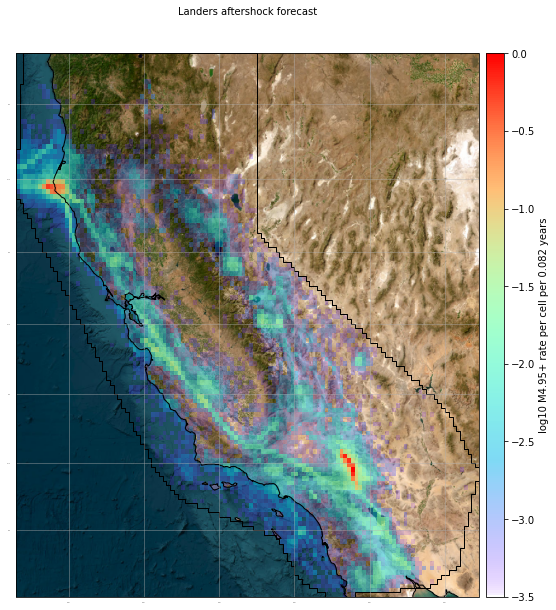

In [8]:
args_forecast = {'title': 'Landers aftershock forecast',
                 'grid_labels': True,
                 'basemap': 'ESRI_imagery',
                 'cmap': 'rainbow',
                 'alpha_exp': 0.5,
                 'projection': cartopy.crs.Mercator(),
                 'clim':[-3.5, 0]}

ax = expected_rates.plot(plot_args = args_forecast)

## 2. Filtrar el catálogo de evaluacion

En este ejemplo, usaremos la función `csep.query_comcat` para descargar el catálogo de evaluación directamente de [ComCat](https://earthquake.usgs.gov/data/comcat/). Luego, filtraremos el catálogo para que este sea consistente con el pronóstico. Esto puede hacerse a través del API de ComCat o utilizando pyCSEP (vea el tutorial sobre pronósticos basados en grillas). En este tutorial, utilizaremos el API de ComCat para hacer el acceso a los datos más rápido, aunque luego tendremos que filtrar el catálogo espacialmente.

In [9]:
# Obtengamos el catálogo ComCat y filtremos el rango de magnitudes
comcat_catalog = csep.query_comcat(start_time, end_time, min_magnitude=forecast.min_magnitude)

# Filtremos el catálogo utilizando la misma región espacial del pronóstico
comcat_catalog = comcat_catalog.filter_spatial(forecast.region)

Fetched ComCat catalog in 0.9094305038452148 seconds.

Downloaded catalog from ComCat with following parameters
Start Date: 1992-06-28 11:57:34.130000+00:00
End Date: 1992-07-24 18:14:36.250000+00:00
Min Latitude: 33.901 and Max Latitude: 36.705
Min Longitude: -118.067 and Max Longitude: -116.285
Min Magnitude: 4.95
Found 20 events in the ComCat catalog.


## 3. Graficar el catálogo
Se puede graficar fácilmente el catálogo utilizando la función plot

<GeoAxes: >

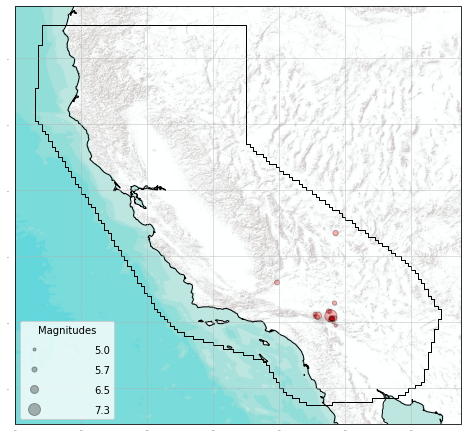

In [11]:
comcat_catalog.plot()

* Ejercicio: Grafique en un mapa un catálogo que esté definido en fechas y en un rango de magnitudes diferentes

## 4. Graficar el pronóstico y el catálogo en un mismo mapa

* Debemos primero crear la figura que contiene el pronóstico, la cual regresará un objeto matplotlib.pyplot.ax.
* Dicho objeto deberá ser pasado a la función catalog.plot() como argumento. 
* Definimos en qué orden aparecerá cada elemento (en este caso, el catálogo estará encima del pronóstico).

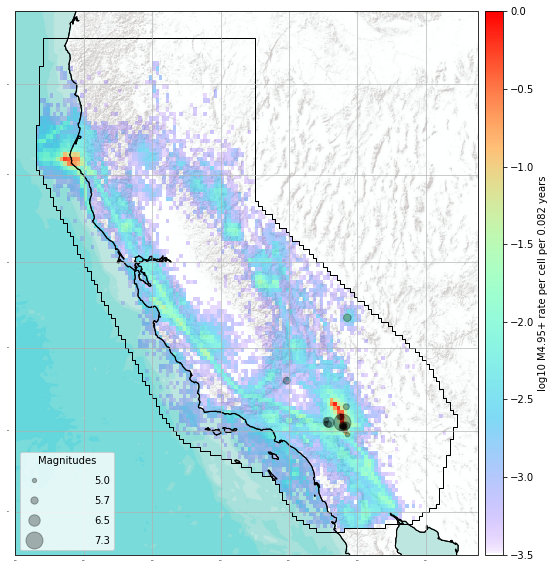

In [13]:
args_catalog = {'basemap': 'ESRI_terrain',
                'markercolor': 'black',
                'markersize': 4}
ax_1 = expected_rates.plot(plot_args=args_forecast)
ax_2 = comcat_catalog.plot(ax=ax_1, plot_args=args_catalog)

## 5. Llevar a cabo las evaluaciones estadísticas

Ahora que tenemos el pronóstico y el catálogo de evaluación, podemos realizar las evaluaciones estadísticas de manera similar a cómo evaluamos los pronósticos basados en grillas en el tutorial anterior. En este caso, realizaremos la prueba número sobre el pronóstico basado en simulaciones utilizando el catálogo ComCat.

Processed 1 catalogs in 6.389617919921875e-05 seconds
Processed 2 catalogs in 0.00385284423828125 seconds
Processed 3 catalogs in 0.005856752395629883 seconds
Processed 4 catalogs in 0.008017778396606445 seconds
Processed 5 catalogs in 0.009645223617553711 seconds
Processed 6 catalogs in 0.010543584823608398 seconds
Processed 7 catalogs in 0.011466741561889648 seconds
Processed 8 catalogs in 0.01551961898803711 seconds
Processed 9 catalogs in 0.01939845085144043 seconds
Processed 10 catalogs in 0.020276308059692383 seconds
Processed 20 catalogs in 0.021074771881103516 seconds
Processed 30 catalogs in 0.0217435359954834 seconds
Processed 40 catalogs in 0.02258777618408203 seconds
Processed 50 catalogs in 0.026920318603515625 seconds
Processed 60 catalogs in 0.027680158615112305 seconds
Processed 70 catalogs in 0.02830672264099121 seconds
Processed 80 catalogs in 0.028952598571777344 seconds
Processed 90 catalogs in 0.02965521812438965 seconds
Processed 100 catalogs in 0.0314695835113525

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


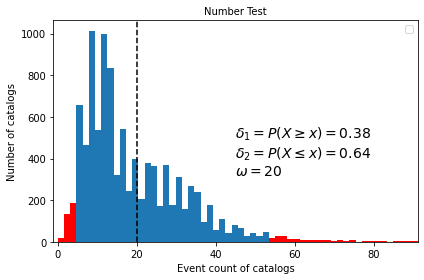

In [14]:
number_test_result = catalog_evaluations.number_test(forecast, comcat_catalog)
ax = number_test_result.plot()

Asimismo, llevaremos a cabo la prueba espacial:

Processed 1 catalogs in 0.0006189346313476562 seconds
Processed 2 catalogs in 0.0071964263916015625 seconds
Processed 3 catalogs in 0.009302854537963867 seconds
Processed 4 catalogs in 0.01132512092590332 seconds
Processed 5 catalogs in 0.01370692253112793 seconds
Processed 6 catalogs in 0.016062259674072266 seconds
Processed 7 catalogs in 0.01868724822998047 seconds
Processed 8 catalogs in 0.02387261390686035 seconds
Processed 9 catalogs in 0.026299715042114258 seconds
Processed 10 catalogs in 0.02781534194946289 seconds
Processed 20 catalogs in 0.03202176094055176 seconds
Processed 30 catalogs in 0.04164719581604004 seconds
Processed 40 catalogs in 0.046782732009887695 seconds
Processed 50 catalogs in 0.05061602592468262 seconds
Processed 60 catalogs in 0.05633139610290527 seconds
Processed 70 catalogs in 0.06056094169616699 seconds
Processed 80 catalogs in 0.06543636322021484 seconds
Processed 90 catalogs in 0.07061171531677246 seconds
Processed 100 catalogs in 0.07472562789916992 s

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


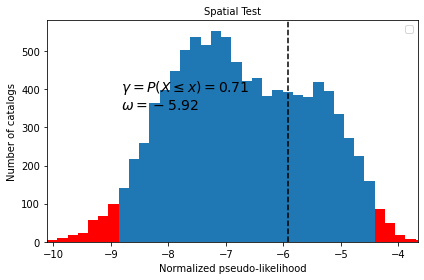

In [15]:
spatial_test_result = catalog_evaluations.spatial_test(forecast, comcat_catalog)
ax = spatial_test_result.plot()

### Preguntas para lxs usurixs

¿Cómo deberiamos interpretar la figura de arriba? ¿Qué nos dicen estos resultados sobre el pronóstico de sismicidad? ¿Qué tan adecuado es el rendimiento espacial de este modelo?